# Trabalho 2 da disciplina de APL
Integrantes do grupo:
* Daniel Brai Gonzales Marcos
* Giovanna Nascimento Antonieti
* Priscila Marques de Oliveira

In [6]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import pandas as pd
import os

In [3]:
tf.__version__

'2.5.0'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Metal device set to: Apple M1
1 Physical GPUs, 1 Logical GPUs


2022-06-15 12:07:11.864963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 12:07:11.865483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. Dataset 
* Load
* Labels
* Pré-processamento 

In [ ]:
# train
dataset_df_train = pd.read_csv('./dataset/train.csv')

# test
dataset_df_test = pd.read_csv('./dataset/test.csv')
dataset_folder ='./dataset/imgs'
class_folders = sorted(os.listdir(dataset_folder))
n_samples=[]
print(class_folders)
print(f'Number of class: {len(class_folders)}')

for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    class_img_filenames = os.listdir(full_class_folder)
    n_samples.append(len(class_img_filenames))
    print(f'Number of Images for Class "{class_folder}": {len(class_img_filenames)}')

In [ ]:
print(f'Mínimo: {min(n_samples)}')
print(f'Máximo: {max(n_samples)}')
n_samples=max(n_samples)

In [ ]:
import random

img_full_paths = []
img_classes = []

# OPTIONAL: just to get the same selected images
random.seed(42)

for class_folder in sorted(os.listdir(dataset_folder)):
    print(f'Class: {class_folder}') 
    
    # translated class
    img_class = class_folder
    
    # get the full class folder pathname
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    # get all image filenames (without their parent dir) for the current class/animal
    class_img_filenames = sorted(os.listdir(full_class_folder))
    
    
    # undersampling from scratch
    random.shuffle(class_img_filenames)
    class_img_filenames = class_img_filenames[:]
    print(f'Number of images: {len(class_img_filenames)}')
    
    for img_filename in class_img_filenames:
        full_img_path = os.path.join(full_class_folder, img_filename)
        
        img_full_paths.append(full_img_path)
        img_classes.append(img_class)
    
    print()

In [ ]:
import pandas as pd

dataset_df = pd.DataFrame({
    'image_pathname': img_full_paths,
    'class': img_classes
})

dataset_df

In [ ]:
imgs = []
classes = []
for i in dataset_df_train['image_pathname']:
    data = dataset_df.loc[dataset_df['image_pathname'] == './dataset/'+i]
    imgs.append(data.iat[0,0])
    classes.append(data.iat[0,1])
    
df_train = pd.DataFrame({
    'image_pathname': imgs,
    'class': classes
})

df_train

In [ ]:
imgs = []
classes = []
for i in dataset_df_test['image_pathname']:
    data = dataset_df.loc[dataset_df['image_pathname'] == './dataset/'+i]
    imgs.append(data.iat[0,0])
    classes.append(data.iat[0,1])
    
df_test = pd.DataFrame({
    'image_pathname': imgs,
    'class': classes
})

df_test

In [ ]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
         tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
         tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)])

In [ ]:
X_train =[]
y_train = []
unique_classes=np.unique(df_train['class'])
for i in unique_classes:
    images = dataset_df.loc[dataset_df['class'] == i]['image_pathname']
    print(f'Loading images for class: {i}')
    imgClass, =np.where(unique_classes==i)
    X_class= []
    for img in images:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        X_class.append(image)
        y_train.append(imgClass[0])
    imgs.append(images)
    print(f'Starting data augmentation...')
    while len(X_class)<n_samples:
        index = np.random.choice(images)
        image = cv2.imread(img)
        image = tf.expand_dims(image, 0)
        augmented_image = data_augmentation(image)
        X_class.append(augmented_image[0])
        y_train.append(imgClass[0])
    print(f'Data augmentation finished\n\n')
    X_train.extend(X_class)

In [ ]:
print(f'Images: {len(X_train)}')
print(f'Labels : {len(y_train)}')

In [ ]:
X_test =[]
y_test =[]

for i in df_test.image_pathname:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_test.append(image)
    classImage = df_test.loc[df_test['image_pathname'] == i].iat[0,1]
    imgClass, = np.where(unique_classes==classImage)
    y_test.append(imgClass[0])

In [ ]:
print(f'Images: {len(X_test)}')
print(f'Labels : {len(y_test)}')

In [ ]:
print(f'Menor valor: {min(y_train)}')
print(f'Maior valor: {max(y_train)}')

In [ ]:
#feature scaling
X_train = np.array(X_train)/255.0
X_test = np.array(X_test)/255.0

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

In [ ]:
print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')

In [ ]:
print(f'X_test.shape: {X_test.shape}')
print(f'y_test (classes): {np.unique(y_test)}')
print(f'y_test.shape: {y_test.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_test: {X_test.min()}')
print(f'Max. value of X_test: {X_test.max()}\n')

In [ ]:
out_dir = './dataset/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

np.save(os.path.join(out_dir, 'train_data.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

np.save(os.path.join(out_dir, 'val_data.npy'), X_val)
np.save(os.path.join(out_dir, 'val_labels.npy'), y_val)

np.save(os.path.join(out_dir, 'test_data.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)

# 2. Modelos

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16

In [8]:
X_train = np.load('./dataset/preprocessed/train_data.npy')
y_train = np.load('./dataset/preprocessed/train_labels.npy')

X_val = np.load('./dataset/preprocessed/val_data.npy')
y_val = np.load('./dataset/preprocessed/val_labels.npy')

X_test = np.load('./dataset/preprocessed/test_data.npy')
y_test = np.load('./dataset/preprocessed/test_labels.npy')

In [29]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## 2.1 Modelo n.1: 1 bloco VGG com SGD

### 2.1.1 Criação do modelo

In [34]:
model_vgg1 = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [35]:
model_vgg1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               10240128  
_________________________________________________________________
dense_9 (Dense)              (None, 83)               

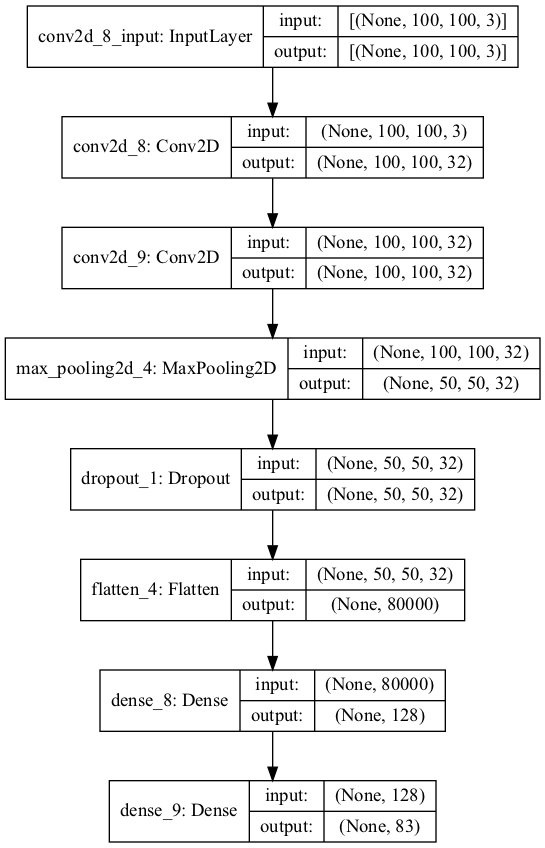

In [36]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(model_vgg1, show_shapes=True)

### 2.1.2 Treinamento

In [37]:
history = None
with tf.device('/GPU:0'):
    history = model_vgg1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-15 12:59:55.259657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 2.8314 - accuracy: 0.3641

2022-06-15 13:01:07.077559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 78s 100ms/step - loss: 2.8314 - accuracy: 0.3641 - val_loss: 2.1481 - val_accuracy: 0.5314
Epoch 2/100
762/762 [==============================] - 59s 77ms/step - loss: 2.0368 - accuracy: 0.5482 - val_loss: 2.0867 - val_accuracy: 0.5360
Epoch 3/100
762/762 [==============================] - 57s 75ms/step - loss: 1.9831 - accuracy: 0.5584 - val_loss: 2.0190 - val_accuracy: 0.5529
Epoch 4/100
762/762 [==============================] - 58s 76ms/step - loss: 1.9679 - accuracy: 0.5601 - val_loss: 2.0546 - val_accuracy: 0.5498
Epoch 5/100
762/762 [==============================] - 58s 77ms/step - loss: 1.9594 - accuracy: 0.5623 - val_loss: 2.0195 - val_accuracy: 0.5528
Epoch 6/100
762/762 [==============================] - 58s 76ms/step - loss: 1.9387 - accuracy: 0.5687 - val_loss: 2.0209 - val_accuracy: 0.5534
Epoch 7/100
762/762 [==============================] - 59s 77ms/step - loss: 1.9294 - accuracy: 0.5691 - val_loss: 2.0052 - val_accuracy: 0.5

Text(0, 0.5, 'Score')

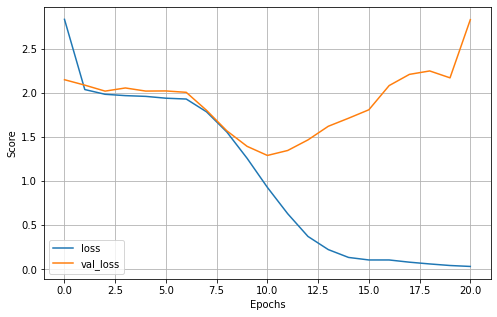

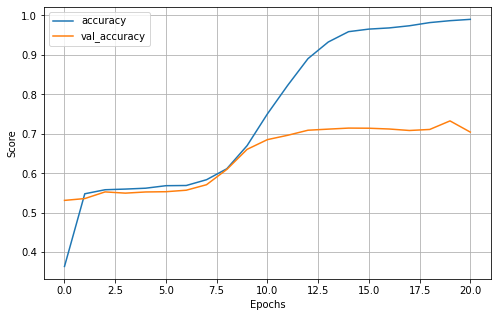

In [38]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.2 Modelo n.2: 1 bloco VGG com Nadam

### 2.2.1 Criação do modelo

In [39]:
model_vgg1_nadam = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.Nadam(learning_rate=0.01 )
model_vgg1_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### 2.2.2 Treinamento

In [40]:
history_nadam = None
with tf.device('/GPU:0'):
    history_nadam = model_vgg1_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-15 13:26:03.773352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 4.0126 - accuracy: 0.1725

2022-06-15 13:27:27.186083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 92s 116ms/step - loss: 4.0126 - accuracy: 0.1725 - val_loss: 2.4382 - val_accuracy: 0.4274
Epoch 2/100
762/762 [==============================] - 79s 103ms/step - loss: 5.1317 - accuracy: 0.1404 - val_loss: 3.5294 - val_accuracy: 0.1958
Epoch 3/100
762/762 [==============================] - 78s 102ms/step - loss: 3.0826 - accuracy: 0.2941 - val_loss: 2.8380 - val_accuracy: 0.3639
Epoch 4/100
762/762 [==============================] - 89s 117ms/step - loss: 2.5852 - accuracy: 0.4084 - val_loss: 2.5675 - val_accuracy: 0.4351
Epoch 5/100
762/762 [==============================] - 79s 103ms/step - loss: 2.1946 - accuracy: 0.4902 - val_loss: 2.2341 - val_accuracy: 0.4853
Epoch 6/100
762/762 [==============================] - 78s 103ms/step - loss: 1.9722 - accuracy: 0.5326 - val_loss: 2.1379 - val_accuracy: 0.5070
Epoch 7/100
762/762 [==============================] - 78s 103ms/step - loss: 4.7804 - accuracy: 0.1598 - val_loss: 4.4209 - val_accurac

Text(0, 0.5, 'Score')

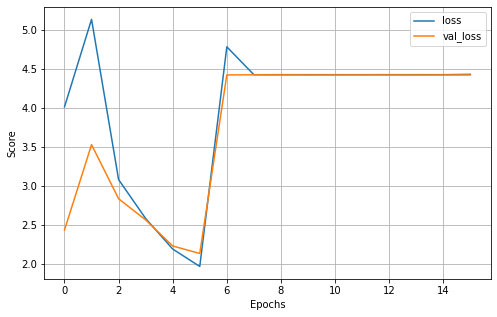

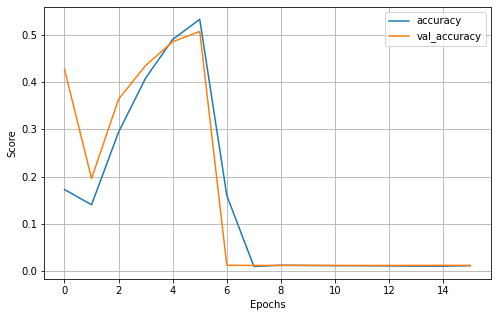

In [41]:
history_df = pd.DataFrame(history_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.3  Modelo n.3: 2 bloco VGG com SGD

In [42]:
model_vgg2 = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [43]:
model_vgg2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)       

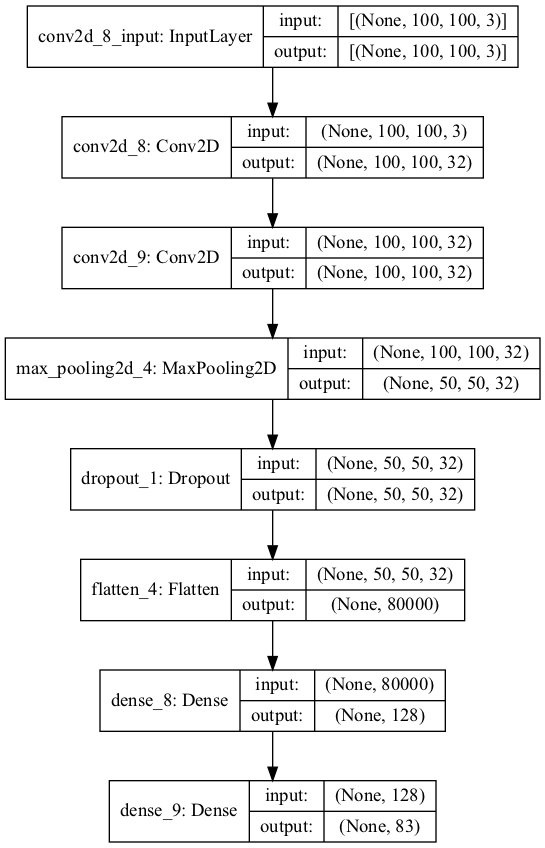

In [44]:
plot_model(model_vgg1, show_shapes=True)

In [45]:
history_vgg2 = None
with tf.device('/GPU:0'):
    history_vgg2 = model_vgg2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-15 13:49:36.134059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 3.3183 - accuracy: 0.2514

2022-06-15 13:50:52.521582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 82s 104ms/step - loss: 3.3183 - accuracy: 0.2514 - val_loss: 2.2687 - val_accuracy: 0.4950
Epoch 2/100
762/762 [==============================] - 77s 101ms/step - loss: 2.1197 - accuracy: 0.5277 - val_loss: 2.0675 - val_accuracy: 0.5421
Epoch 3/100
762/762 [==============================] - 87s 114ms/step - loss: 2.0231 - accuracy: 0.5501 - val_loss: 2.0317 - val_accuracy: 0.5496
Epoch 4/100
762/762 [==============================] - 86s 113ms/step - loss: 1.9975 - accuracy: 0.5543 - val_loss: 2.0544 - val_accuracy: 0.5421
Epoch 5/100
762/762 [==============================] - 84s 110ms/step - loss: 1.9421 - accuracy: 0.5615 - val_loss: 1.8863 - val_accuracy: 0.5564
Epoch 6/100
762/762 [==============================] - 86s 113ms/step - loss: 1.7675 - accuracy: 0.5742 - val_loss: 1.6946 - val_accuracy: 0.5733
Epoch 7/100
762/762 [==============================] - 87s 114ms/step - loss: 1.5877 - accuracy: 0.6001 - val_loss: 1.5559 - val_accurac

Text(0, 0.5, 'Score')

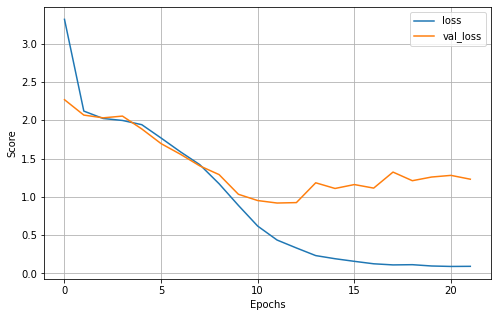

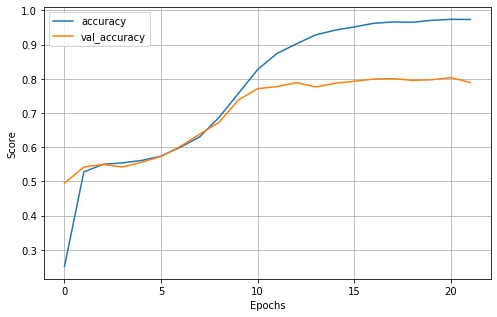

In [46]:
history_df = pd.DataFrame(history_vgg2.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.3 Modelo n.4: 2 bloco VGG com Nadam

In [47]:
model_vgg2_nadam = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.Nadam(learning_rate=0.01, )
model_vgg2_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [48]:
model_vgg2_nadam.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 64)       

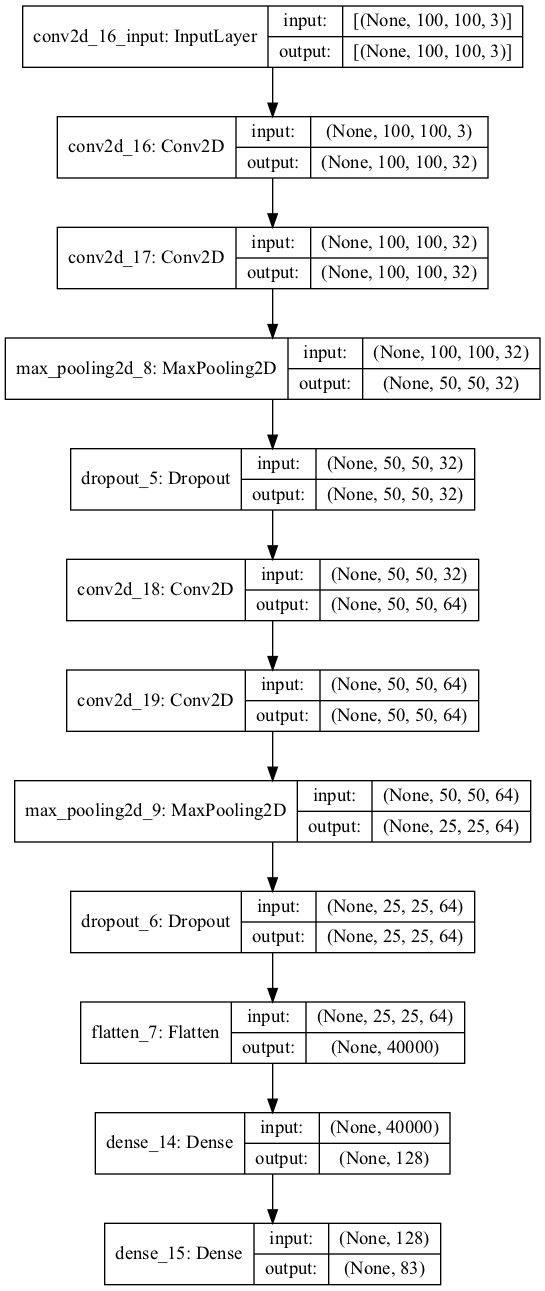

In [50]:
plot_model(model_vgg2_nadam, show_shapes=True)

In [56]:
history_vgg2_nadam = None
with tf.device('/GPU:0'):
    history_vgg2_nadam = model_vgg2_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100
762/762 [==============================] - 80s 104ms/step - loss: 4.4238 - accuracy: 0.0109 - val_loss: 4.4226 - val_accuracy: 0.0120
Epoch 2/100
762/762 [==============================] - 90s 119ms/step - loss: 4.4240 - accuracy: 0.0124 - val_loss: 4.4215 - val_accuracy: 0.0121
Epoch 3/100
762/762 [==============================] - 77s 100ms/step - loss: 4.4246 - accuracy: 0.0111 - val_loss: 4.4207 - val_accuracy: 0.0120
Epoch 4/100
762/762 [==============================] - 78s 102ms/step - loss: 4.4240 - accuracy: 0.0119 - val_loss: 4.4208 - val_accuracy: 0.0120
Epoch 5/100
762/762 [==============================] - 77s 100ms/step - loss: 4.4240 - accuracy: 0.0105 - val_loss: 4.4211 - val_accuracy: 0.0120
Epoch 6/100
762/762 [==============================] - 79s 104ms/step - loss: 4.4240 - accuracy: 0.0115 - val_loss: 4.4208 - val_accuracy: 0.0121
Epoch 7/100
762/762 [==============================] - 81s 106ms/step - loss: 4.4240 - accuracy: 0.0112 - val_loss: 4.4213 -

Text(0, 0.5, 'Score')

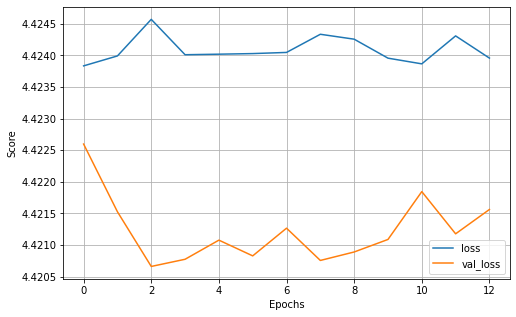

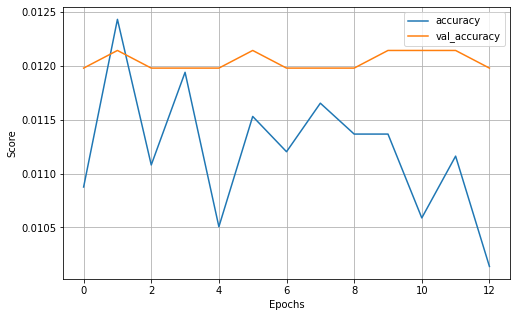

In [57]:
history_df = pd.DataFrame(history_vgg2_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.5 Modelo n.5: 3 bloco VGG com SGD

In [58]:
model_vgg3 = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(128,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(128,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [59]:
model_vgg3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)       

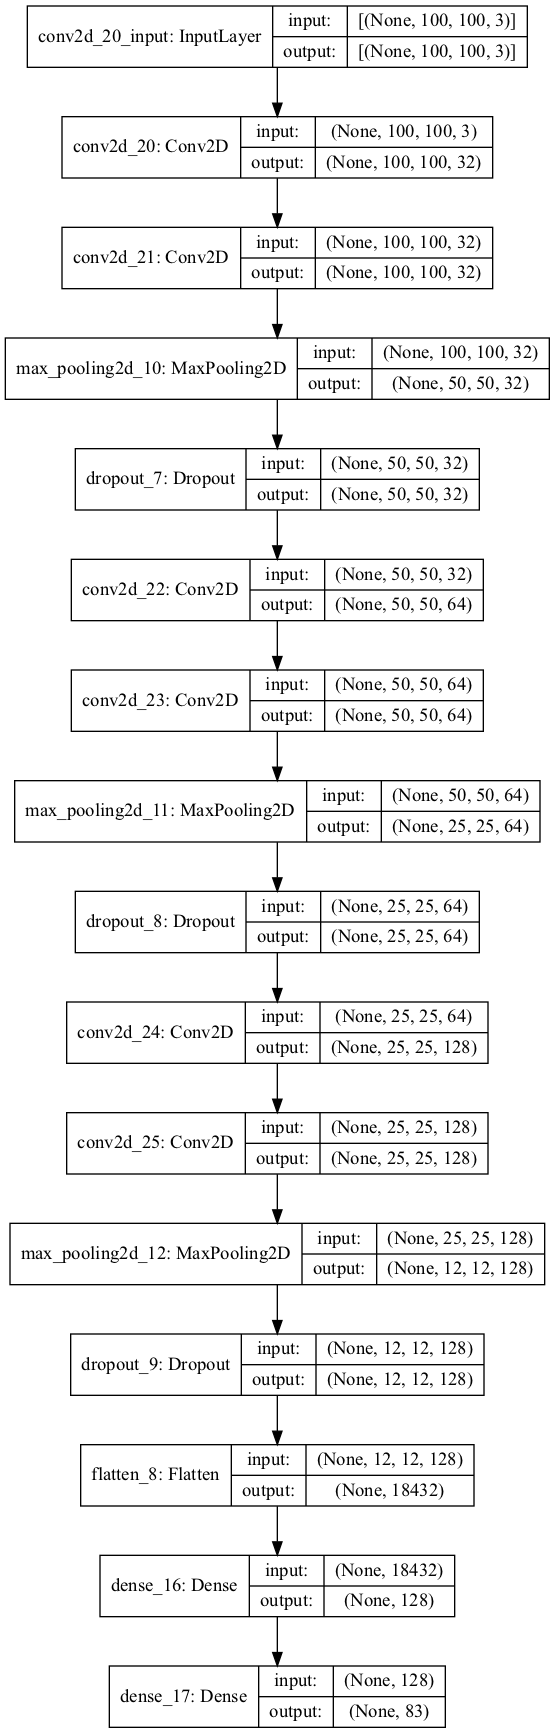

In [60]:
plot_model(model_vgg3, show_shapes=True)

In [61]:
history_vgg3 = None
with tf.device('/GPU:0'):
    history_vgg3 = model_vgg3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-15 16:08:00.767584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 3.8706 - accuracy: 0.1139

2022-06-15 16:09:23.749494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 90s 113ms/step - loss: 3.8706 - accuracy: 0.1139 - val_loss: 3.1319 - val_accuracy: 0.2698
Epoch 2/100
762/762 [==============================] - 85s 111ms/step - loss: 2.2900 - accuracy: 0.4776 - val_loss: 2.1414 - val_accuracy: 0.5247
Epoch 3/100
762/762 [==============================] - 97s 127ms/step - loss: 2.0495 - accuracy: 0.5430 - val_loss: 2.0503 - val_accuracy: 0.5442
Epoch 4/100
762/762 [==============================] - 98s 128ms/step - loss: 2.0093 - accuracy: 0.5515 - val_loss: 2.0596 - val_accuracy: 0.5416
Epoch 5/100
762/762 [==============================] - 99s 129ms/step - loss: 2.0022 - accuracy: 0.5524 - val_loss: 2.0606 - val_accuracy: 0.5411
Epoch 6/100
762/762 [==============================] - 98s 128ms/step - loss: 1.9696 - accuracy: 0.5593 - val_loss: 2.0318 - val_accuracy: 0.5472
Epoch 7/100
762/762 [==============================] - 104s 137ms/step - loss: 1.9079 - accuracy: 0.5651 - val_loss: 1.9210 - val_accura

Text(0, 0.5, 'Score')

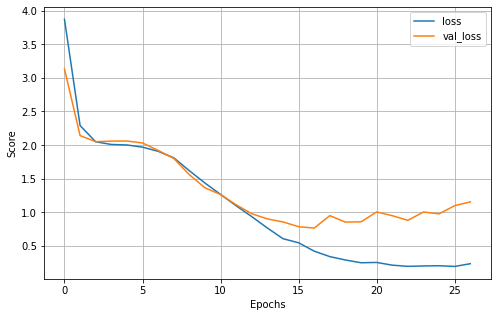

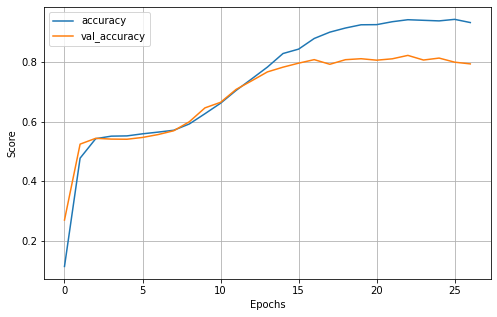

In [62]:
history_df = pd.DataFrame(history_vgg3.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.6 Modelo n.6: 3 bloco VGG com Nadam

In [64]:
model_vgg3_nadam = Sequential(layers=[
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(32,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(64,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Conv2D(128,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform', input_shape=(100,100,3)),
    Conv2D(128,(3,3), activation='relu',padding='same', kernel_initializer='he_uniform'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(83, activation='softmax')
])
opt = tf.keras.optimizers.Nadam(learning_rate=0.01,  )
model_vgg3_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [65]:
model_vgg3_nadam.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)       

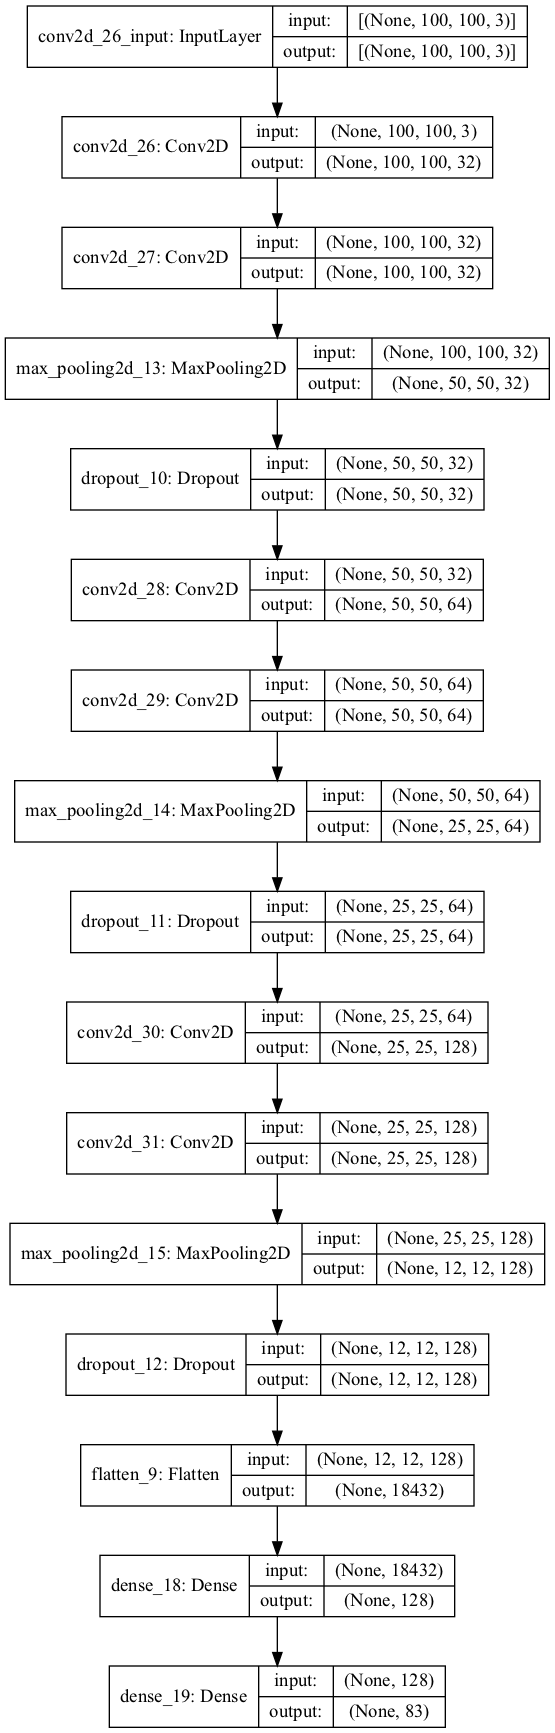

In [66]:
plot_model(model_vgg3_nadam,show_shapes=True)

In [67]:
history_vgg3_nadam = None
with tf.device('/GPU:0'):
    history_vgg3_nadam = model_vgg3_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

Epoch 1/100


2022-06-15 18:10:04.543632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 4.9031 - accuracy: 0.0112

2022-06-15 18:11:30.834869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 93s 116ms/step - loss: 4.9031 - accuracy: 0.0112 - val_loss: 4.4213 - val_accuracy: 0.0120
Epoch 2/100
762/762 [==============================] - 83s 108ms/step - loss: 4.4242 - accuracy: 0.0098 - val_loss: 4.4210 - val_accuracy: 0.0120
Epoch 3/100
762/762 [==============================] - 84s 110ms/step - loss: 4.4242 - accuracy: 0.0109 - val_loss: 4.4210 - val_accuracy: 0.0120
Epoch 4/100
762/762 [==============================] - 85s 111ms/step - loss: 4.4240 - accuracy: 0.0108 - val_loss: 4.4207 - val_accuracy: 0.0120
Epoch 5/100
762/762 [==============================] - 83s 109ms/step - loss: 4.4241 - accuracy: 0.0108 - val_loss: 4.4212 - val_accuracy: 0.0121
Epoch 6/100
762/762 [==============================] - 85s 112ms/step - loss: 4.4236 - accuracy: 0.0114 - val_loss: 4.4224 - val_accuracy: 0.0121
Epoch 7/100
762/762 [==============================] - 87s 114ms/step - loss: 4.4240 - accuracy: 0.0107 - val_loss: 4.4208 - val_accurac

Text(0, 0.5, 'Score')

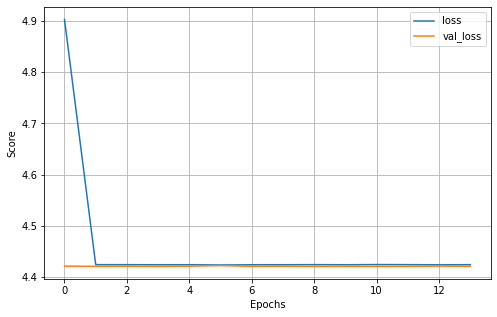

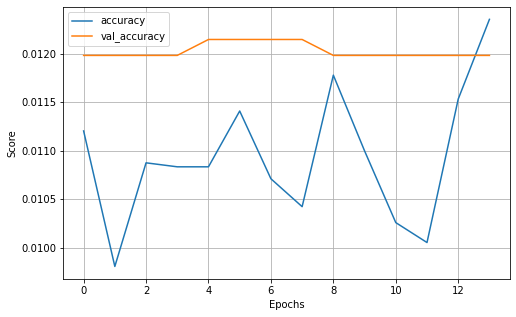

In [68]:
history_df = pd.DataFrame(history_vgg3_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.7 Modelo n.7: Transfer learning VGG16 com SGD

### 2.7.1 Criação do modelo

In [80]:
base_vgg = VGG16(include_top=None,  
                   weights="imagenet", 
                   input_shape=(100, 100, 3))  
base_vgg.trainable = False

In [81]:
model_vgg_sgd = Sequential([
    base_vgg,
    
    Flatten(),
    
    Dense(254, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dense(83, activation='softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, )
model_vgg_sgd.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [82]:
model_vgg_sgd.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 254)               1170686   
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32640     
_________________________________________________________________
dense_28 (Dense)             (None, 83)                10707     
Total params: 15,928,721
Trainable params: 1,214,033
Non-trainable params: 14,714,688
_________________________________________________________________


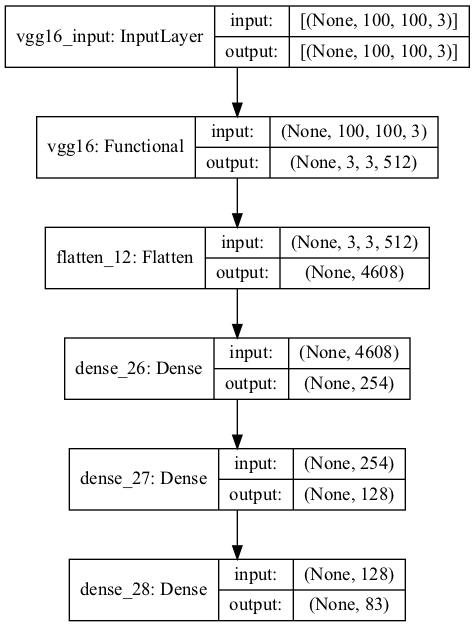

In [83]:
plot_model(model_vgg_sgd, show_shapes=True)

### 2.7.1 Treinamento do modelo

In [ ]:
history_vgg_sgd = None
with tf.device('/GPU:0'):
    history_vgg_sgd = model_vgg_sgd.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100


2022-06-15 20:28:30.824264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - ETA: 0s - loss: 2.8400 - accuracy: 0.3529

2022-06-15 20:30:47.881694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


762/762 [==============================] - 197s 221ms/step - loss: 2.8400 - accuracy: 0.3529 - val_loss: 1.8356 - val_accuracy: 0.5738
Epoch 2/100
762/762 [==============================] - 163s 214ms/step - loss: 1.6760 - accuracy: 0.5909 - val_loss: 1.6423 - val_accuracy: 0.6020
Epoch 3/100
762/762 [==============================] - 183s 241ms/step - loss: 1.5122 - accuracy: 0.6202 - val_loss: 1.5349 - val_accuracy: 0.6155
Epoch 4/100
762/762 [==============================] - 195s 255ms/step - loss: 1.3942 - accuracy: 0.6422 - val_loss: 1.5000 - val_accuracy: 0.6265
Epoch 5/100
762/762 [==============================] - 191s 250ms/step - loss: 1.3208 - accuracy: 0.6577 - val_loss: 1.4667 - val_accuracy: 0.6276
Epoch 6/100
762/762 [==============================] - 183s 240ms/step - loss: 1.2647 - accuracy: 0.6690 - val_loss: 1.3845 - val_accuracy: 0.6457
Epoch 7/100
762/762 [==============================] - 188s 246ms/step - loss: 1.2203 - accuracy: 0.6770 - val_loss: 1.3775 - val_

In [ ]:
history_df = pd.DataFrame(history_vgg_sgd.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.8 Modelo n.8: Transfer learning com Nadam

### 2.8.1 Criação do modelo

In [ ]:
model_vgg_nadam = Sequential([
    base_vgg,
    
    Flatten(),
    
    Dense(254, activation='relu'),
    
    Dense(128, activation='relu'),
    
    Dense(83, activation='softmax')
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.01,  )
model_vgg_nadam.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model_vgg_nadam.summary()

In [ ]:
plot_model(model_vgg_nadam, show_shapes=True)

### 2.8.2 Treinamento do modelo

In [ ]:
history_vgg_nadam = None
with tf.device('/GPU:0'):
    history_vgg_nadam = model_vgg_nadam.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
history_df = pd.DataFrame(history_vgg_nadam.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
# plt.xticks(range(100))
plt.xlabel('Epochs')
plt.ylabel('Score')


In [ ]:
model_vgg1.save('./models/one-block-vgg-sgd.h5')
model_vgg1_nadam.save('./models/one-block-vgg-nadam.h5')
model_vgg2.save('./models/two-blocks-vgg-sgd.h5')
model_vgg2_nadam.save('./models/two-blocks-vgg-nadam.h5')
model_vgg3.save('./models/three-blocks-vgg-sgd.h5')
model_vgg3_nadam.save('./models/three-blocks-vgg-nadam.h5')
model_vgg_sgd.save('./models/transfer-vgg-sgd.h5')
model_vgg_nadam.save('./models/transfer-vgg-nadam.h5')

# 3. Validação

In [ ]:
print(f'Evaluate 1VGG +sgd: {model_vgg1.evaluate(X_test, y_test)}')
print(f'Evaluate 1VGG +nadam: {model_vgg1_nadam.evaluate(X_test, y_test)}')

print(f'Evaluate 2VGG +sgd: {model_vgg2.evaluate(X_test, y_test)}')
print(f'Evaluate 2VGG +nadam: {model_vgg2_nadam.evaluate(X_test, y_test)}')
      
print(f'Evaluate 3VGG +sgd: {model_vgg3.evaluate(X_test, y_test)}')
print(f'Evaluate 3VGG +nadam: {model_vgg3_nadam.evaluate(X_test, y_test)}')
      
print(f'Evaluate VGG16 +sgd: {model_vgg_sgd.evaluate(X_test, y_test)}')
print(f'Evaluate VGG16 +nadam: {model_vgg_nadam.evaluate(X_test, y_test)}')

In [ ]:
y_vgg1 = model_vgg1.predict(X_test)
y_vgg1_nadam = model_vgg1_nadam.predict(X_test)
y_vgg2 = model_vgg2.predict(X_test)
y_vgg2_nadam = model_vgg2_nadam.predict(X_test)
y_vgg3 = model_vgg3.predict(X_test)
y_vgg3_nadam = model_vgg3_nadam.predict(X_test)
y_vgg = model_vgg_sgd.predict(X_test)
y_vgg_nadam = model_vgg_nadam.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(f'Accuracy 1VGG +sgd: {accuracy_score( y_test,y_vgg1)}')
print(f'Accuracy 1VGG +nadam: {accuracy_score(y_test, y_vgg1_nadam)}')

print(f'Accuracy 2VGG +sgd: {accuracy_score(y_test, y_vgg2)}')
print(f'Accuracy 2VGG +nadam: {accuracy_score(y_test, y_vgg2_nadam)}')
      
print(f'Accuracy 3VGG +sgd: {accuracy_score(y_test, y_vgg3)}')
print(f'Accuracy 3VGG +nadam: {accuracy_score(y_test, y_vgg3_nadam)}')
      
print(f'Accuracy VGG16 +sgd: {accuracy_score(y_test, y_vgg)}')
print(f'Accuracy VGG16 +nadam: {accuracy_score(y_test, y_vgg_nadam)}')